# First optimization problem using NRV

In this tutorial, the optimization formalism used in NRV is illustrated through a detailed example.

## Principle

In NRV, an optimization problem is composed of two components, as illustrated by the figure below: 
 - **An optimizer** : based on third party libraries (``scipy`` and ``pyswarms``) algorithms.
 - **A cost function**: a function from $\real^n$ to $\real$ that should be minimized.


The framework introduces an easy way to evaluate the impact of specific parameters in simulations and final cost assessment through a `Cost_Function`-class consisting in:

 - A filter: an optional Python `callable`-object for vector formatting or space restriction.
 - A static context: the initial point of the simulation, often a NRV-nmod object like axon, fascicle, or nerve, with a `simulate`-method.
 - A `ContextModifier`-object: creates an updated local context from the static context and input vector.
 - A `CostEvaluation`-object: evaluates a user-defined cost using simulation results. It's a generic Python `callable`-class, allowing user-defined functions.





![alt text](../docs/images/optim.png)


## Context

The objective of the following optimization is to maximize the fibre recruitment while minimizing the stimulus energy.

To ease this tutorial the understanding, two optimizations with the same objective but different neural contexts are presented bellow.

 1. The stimulation is applied on a single fibre ($N_{axon}=1$).

 2. A monofasciclar nerve filled with 98 myelinated fibres ($N_{axon}=98$).

The stimulus is a simple 


The cost evaluation function can be written as: 
$$
    Cost = \alpha_e\sum_{t_k}{i_{stim}^2(t_k)}+\alpha_r(N_{axon}-N_{recruited})
$$

Where $t_k$ is the discrete time step of the simulation, $N_{recruited}$ is the number of fibre triggered by the stimulation, and $\alpha_e$ and $\alpha_r$ are two weighting coefficients.



In [2]:
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
np.random.seed(seed=10)

sys.path.append("../")
import nrv
test_name = "Tutorial_5"

dir_res = f"./{test_name}/"
if not os.path.isdir(dir_res):
    os.mkdir(dir_res)

nerve_file = dir_res + "nerve.json"
axon_file = dir_res + "myelinated_axon.json"

## First optimization: Single axon

### Cost function

As explain above, to define the cost function of the optimization problem

#### Static context

NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 11368
NRV INFO: Number of elements : 80818
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 4.2561633586883545 s


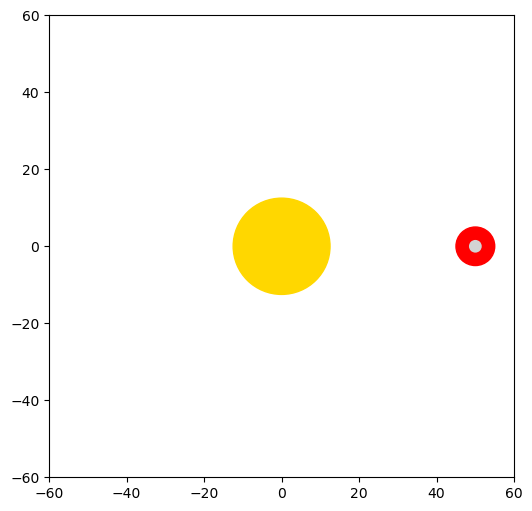

In [3]:
ax_l = 10000 # um
ax_d=10
ax_y=50
ax_z=0
axon_1 = nrv.myelinated(L=ax_l, d=ax_d, y=ax_y, z=ax_z)

life_d = 25 # um
life_length = 1000 # um
life_y_c_0 = 0
life_z_c_0 = 0
LIFE_stim0 = nrv.FEM_stimulation()
LIFE_stim0.reshape_nerve(Length=ax_l)

life_x_0_offset = (ax_l-life_length)/2
elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

start = 1 # ms
I_cathod = 40 # uA
I_anod = I_cathod/5
T_cathod = 60e-3 # ms
T_inter = 40e-3 # ms
stim0 = nrv.stimulus()
stim0.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)
LIFE_stim0.add_electrode(elec_0, stim0)

axon_1.attach_extracellular_stimulation(LIFE_stim0)
axon_1.get_electrodes_footprints_on_axon()
_ = axon_1.save(save=True, fname=axon_file, extracel_context=True)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
axon_1.plot(ax)
ax.set_xlim((-1.2*ax_y, 1.2*ax_y))
ax.set_ylim((-1.2*ax_y, 1.2*ax_y))

del axon_1

## Optimization



In [4]:
## Cost function definition
static_context = axon_file

fname0 = dir_res + "/energy_optim_pso_biphasic.json"
#fname2 = dir_res + "/energy_optim_pso_spline2pts.json"

costfname0 = dir_res + "/energy_cost_biphasic.csv"
#costfname2 = dir_res + "/energy_cost_spline2pts.csv"

t_sim = 5
t_start = 1
t_end = 0.5
I_max_abs = 100
t_bound = (0, t_end)
I_bound = (-I_max_abs, 0)
duration_bound = (0.01, 0.5)


#### Cost Evaluation

The `cost_evaluaiton` is a function or a callable class instance computing a cost from a simulation `results`.

 *NB: A typical cost evaluation function should take as parameter a `sim_results` object and eventual `kwargs` parameters and return a corresponding cost (`float`)*


A few cost evaluations class are already implemented in NRV compatible with algebraical operations. Here the cost evaluation is generated using two classes implemented in NRV:
 1. `recrutement_count_CE`: computing the number of triggered fibres

 2. `stim_energy_CE`: computing a value proportional to the stimulus energy,


In [5]:
costR = nrv.recrutement_count_CE(reverse=True)
costC = nrv.stim_energy_CE()

cost_evaluation = costR + 0.01 * costC


#### Context modifier

The `context_modifier` is a function or a callable class instance which modifies s


In [6]:
context_modifier0 = nrv.biphasic_stimulus_CM(start=t_start, I_cathod="0", T_cathod=0.1*t_end, I_anod=0)

In [7]:
kwarg_sim = {
    "return_parameters_only":False,
    "save_results":False,
    "postproc_script":"is_excited",
    "dt":0.002,
}

my_cost0 = nrv.CostFunction(
    static_context=static_context,
    context_modifier=context_modifier0,
    cost_evaluation=cost_evaluation,
    kwargs_S=kwarg_sim,
    t_sim=t_sim,
    file_name=costfname0,
)

In [8]:
# Problem definition
test_prob = nrv.Problem(save_problem_results=False)
test_prob.optimizer = nrv.PSO_optimizer()

bounds0 = (
    (0, I_max_abs),
)
pso_kwargs0 = {
    "maxiter" : 50,
    "n_particles" : 20,
    "opt_type" : "local",
    "options": {'c1': 0.45, 'c2': 0.45, 'w': 0.75, 'k': 5, 'p': 1},
    "bh_strategy": "reflective",
    "dimensions" : 1,
    "bounds" : bounds0,
    "comment":"pulse"}

test_prob.costfunction = my_cost0

res0 = test_prob(problem_fname=fname0, **pso_kwargs0)



((0, 100),) [10.14695342695113]


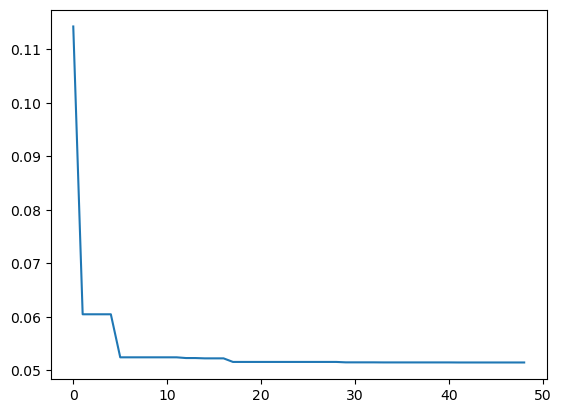

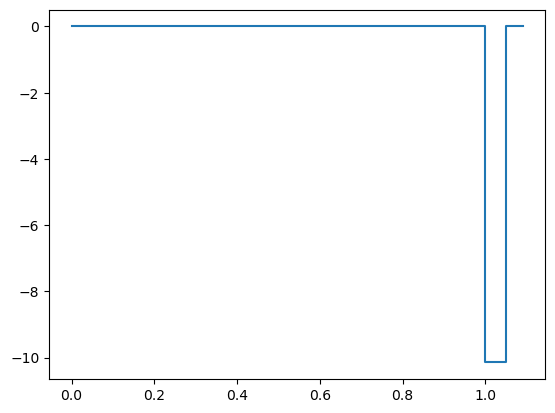

In [ ]:
res0.plot_cost_history(generatefigure=True)
stim = context_modifier0(res0.x, static_context).extra_stim.stimuli[0]
fig, ax = plt.subplots()
stim.plot(ax)

print(bounds0, res0.x)


## Second optimization

NRV INFO: On 100 axons to generate, there are 100 Myelinated and 0 Unmyelinated
NRV INFO: Axon packing initiated. This might take a while...


100%|██████████| 20000/20000 [00:01<00:00, 15418.33it/s]


NRV INFO: Packing done!
NRV INFO: From Fascicle 0: Electrode/Axons overlap, 2 axons will be removed from the fascicle
NRV INFO: 100 axons remaining
NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 36
NRV INFO: Number of nodes : 13638
NRV INFO: Number of elements : 97211
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 4.748852252960205 s


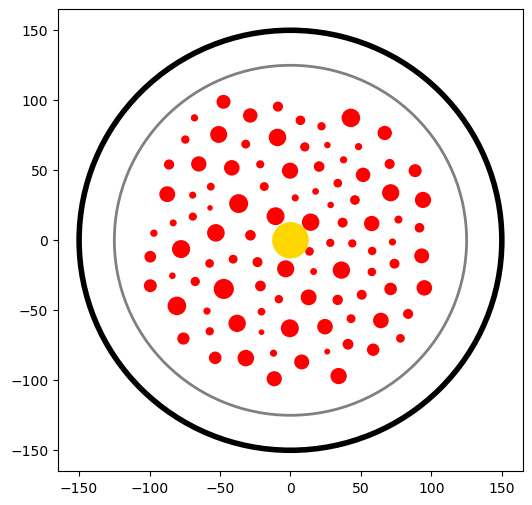

In [ ]:
outer_d = 5 # mm
nerve_d = 300 # um
nerve_l = 10000 # um

fasc1_d = 250 # um
fasc1_y = 0
fasc1_z = 0
n_ax1 = 100


nerve_1 = nrv.nerve(length=nerve_l, diameter=nerve_d, Outer_D=outer_d)

axons_diameters, axons_type, M_diam_list, U_diam_list = nrv.create_axon_population(n_ax1, percent_unmyel=0, M_stat="Ochoa_M", U_stat="Ochoa_U",)

fascicle_1 = nrv.fascicle(ID=0)      #we can add diameter here / no need to call define_circular_contour (not tested)
fascicle_1.define_circular_contour(fasc1_d)
fascicle_1.fill_with_population(axons_diameters, axons_type, fit_to_size=True,delta=5)
fascicle_1.generate_random_NoR_position()
nerve_1.add_fascicle(fascicle=fascicle_1, y=fasc1_y, z=fasc1_z)

# LIFE in neither of the two fascicles
LIFE_stim0 = nrv.FEM_stimulation()
life_x_0_offset = (nerve_l-life_length)/2
elec_0 = nrv.LIFE_electrode("LIFE", life_d, life_length, life_x_0_offset, life_y_c_0, life_z_c_0)

stim0 = nrv.stimulus()
stim0.biphasic_pulse(start, I_cathod, T_cathod, I_anod, T_inter)
LIFE_stim0.add_electrode(elec_0, stim0)
nerve_1.attach_extracellular_stimulation(LIFE_stim0)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
nerve_1.plot(ax)

nerve_1.compute_electrodes_footprints()
_ = nerve_1.save(fname=nerve_file, extracel_context=True)